## Setup

Please execute the cell(s) below to initialize the notebook environment.

In [ ]:
# @title Install dependencies
# !pip install poetry

In [ ]:
# @title Install SMorph Python module
# !pip install https://github.com/swanandlab/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [1]:
# Imports
on_colab = 'google.colab' in str(get_ipython())

import warnings
warnings.filterwarnings('ignore')

import json
from os import getcwd, path, listdir

if not on_colab:
  import napari
import smorph as sm
import smorph.util.autocrop as ac
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

import PyQt5
import superqt
from skimage import exposure, restoration
from vispy.geometry.rect import Rect
from smorph.util.autocrop._postprocessing import _segment_clump

from magicgui import magicgui

In [2]:
# Helper function
def view_3D(*args):
    """Views a 3D image."""
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0], ndisplay=3, scale=SCALE)
            for itr in range(1, n_images):
                if args[itr]['data'].max() > 1 and args[itr]['data'].max() % 1 == 0:
                    if 'colormap' in args[itr].keys():
                        del args[itr]['colormap']
                    if 'gamma' in args[itr].keys():
                        del args[itr]['gamma']
                    viewer.add_labels(**args[itr], scale=SCALE)
                else:
                    viewer.add_image(**args[itr], scale=SCALE)

---

In [ ]:
import skimage
ims = []
labs = []
im = np.load(cache_dir + listdir(cache_dir)[0])
im_name = '.'.join(path.basename(listdir(cache_dir)[0]).split('.')[:-1])
roi_polygon = ac.select_ROI(im, im_name, cache_dir+im_name + '_ML.roi')
original = ac.mask_ROI(original, roi_polygon)
preprocessed = ac.mask_ROI(im, roi_polygon)

# get the maximally inscribed rectangle
ll, ur = ac.get_maximal_rectangle([roi_polygon])
ll, ur = np.ceil(ll).astype(int), np.floor(ur).astype(int)
llx, lly = ll; urx, ury = ur
llx -= roi_polygon[:, 0].min(); urx -= roi_polygon[:, 0].min()
lly -= roi_polygon[:, 1].min(); ury -= roi_polygon[:, 1].min()

denoiser = ac.calibrate_nlm_denoiser(preprocessed[:, lly:ury, llx:urx])
denoise_parameters = denoiser.keywords['denoiser_kwargs']
refdenoised = ac.denoise(preprocessed, denoise_parameters)
refdenoised = (refdenoised - refdenoised.min()) / (refdenoised.max() - refdenoised.min())


all_thresh = []
ctr = 0
for name in listdir(cache_dir):
  if name.split('.')[-1] == 'npy':
    if ctr%4 == 0:
      im = np.load(cache_dir + name)
      im_name = '.'.join(path.basename(name).split('.')[:-1])
      try:
        roi_polygon = ac.select_ROI(im, im_name, cache_dir+im_name + '_ML.roi')
        original = ac.mask_ROI(original, roi_polygon)
        preprocessed = ac.mask_ROI(im, roi_polygon)

        # get the maximally inscribed rectangle
        ll, ur = ac.get_maximal_rectangle([roi_polygon])
        ll, ur = np.ceil(ll).astype(int), np.floor(ur).astype(int)
        llx, lly = ll; urx, ury = ur
        llx -= roi_polygon[:, 0].min(); urx -= roi_polygon[:, 0].min()
        lly -= roi_polygon[:, 1].min(); ury -= roi_polygon[:, 1].min()

        denoiser = ac.calibrate_nlm_denoiser(preprocessed[:, lly:ury, llx:urx])
        denoise_parameters = denoiser.keywords['denoiser_kwargs']
        denoised = ac.denoise(preprocessed, denoise_parameters)
        denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
        denoised = skimage.exposure.match_histograms(denoised, refdenoised)

        lo, hi = skimage.filters.threshold_triangle(denoised[:, lly:ury, llx:urx]), .12# skimage.filters.threshold_otsu(denoised[:, lly:ury, llx:urx])
        ims.append(denoised)
        labs.append(skimage.measure.label(skimage.filters.apply_hysteresis_threshold(denoised, lo, hi)))
        print(lo, hi)
      except:
        pass
    ctr += 1
    # curr_th = []
    # for th in sm.util.THRESHOLD_METHODS:
    #   val = None
    #   try:
    #     val = eval(f'skimage.filters.threshold_{th}(denoised[:, lly:ury, llx:urx])')
    #   except Exception as e:
    #     print(name, e)
    #     val = None
    #   curr_th.append(val)
    # all_thresh.append(curr_th)

In [ ]:
viewer = napari.view_image(ims[0], scale=(1.0785801681301463, 0.6918881978764917, 0.6918881978764917), ndisplay=3)
viewer.add_labels(labs[0], scale=(1.0785801681301463, 0.6918881978764917, 0.6918881978764917))
for i in range(1, len(ims)):
    viewer.add_image(ims[i], scale=(1.0785801681301463, 0.6918881978764917, 0.6918881978764917), visible=False)
    viewer.add_labels(labs[i], scale=(1.0785801681301463, 0.6918881978764917, 0.6918881978764917), visible=False)

In [ ]:
1.0785801681301463 * 0.6918881978764917 * 0.6918881978764917 * 1024 * 1024 * 36

In [ ]:
import pandas as pd
df = pd.DataFrame(all_thresh, columns=sm.util.THRESHOLD_METHODS)

In [ ]:
df.describe()

In [ ]:
df.boxplot(figsize=(15, 10))

In [ ]:
df.hist(figsize=(15, 10))

---
## Step 0: Import Reference image

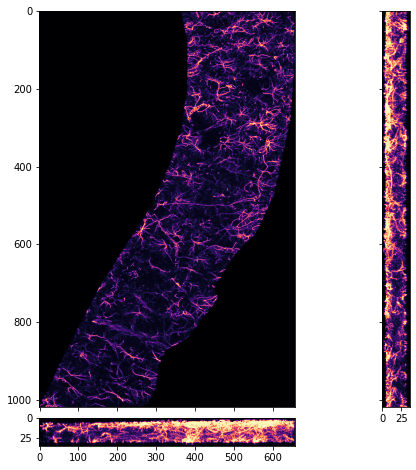

In [3]:
REF_IMAGE = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_28 DAYS/control_28 days/CONTROL_MSP3.1M_1_SINGLE MARK_20X_SEC 1_RIGHT HILUS_28 DAYczi.czi'
DECONV_ITR = 30

cache_dir = 'Cache/'
NAME_ROI = 'ML'
REF_SUFFIX = f'-{NAME_ROI}-ref.npy'
try:
  cached_filename = '.'.join(path.basename(REF_IMAGE).split('.')[:-1]) + REF_SUFFIX
  refdenoised = np.load(cache_dir + cached_filename)
except:
  cached_filename = '.'.join(path.basename(REF_IMAGE).split('.')[:-1]) + '.npy'
  cached = False

  try:
    if cached_filename in listdir(cache_dir):
      refdeconvolved = np.load(cache_dir + cached_filename)
      cached = True
    else:
      raise ValueError('Preprocessed image not cached')
  except:
    cached = False

    refdeconvolved = ac.deconvolve(ac.imread(REF_IMAGE), REF_IMAGE, iters=DECONV_ITR)

  CLIP_LIMIT = .02

  if cached:
    refpreprocessed = refdeconvolved
  else:
    background = restoration.rolling_ball(refdeconvolved, radius=(min(refdeconvolved.shape)-1)//2)
    refpreprocessed = exposure.equalize_adapthist(refdeconvolved-background, clip_limit=CLIP_LIMIT)


  SELECT_ROI = True
  REF_FILE_ROI = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_28 DAYS/control_28 days/CONTROL_MSP3.1M_1_SINGLE MARK_20X_SEC 1_RIGHT HILUS_28 DAYczi_ML.roi'
  roi_polygon = None

  %matplotlib inline

  IMG_NAME = '.'.join(REF_IMAGE.split('/')[-1].split('.')[:-1])
  roi_polygon = np.array([[0, 0], [refpreprocessed.shape[0]-1, 0], [refpreprocessed.shape[0]-1, refpreprocessed.shape[1]-1], [0, refpreprocessed.shape[1]-1]]) if not SELECT_ROI else ac.select_ROI(refpreprocessed, IMG_NAME + '-' + NAME_ROI, REF_FILE_ROI)

  refpreprocessed = ac.mask_ROI(refpreprocessed, roi_polygon)
  ll, ur = ac.get_maximal_rectangle([roi_polygon])
  if SELECT_ROI:
    ll, ur = np.ceil(ll).astype(int), np.floor(ur).astype(int)
    llx, lly = ll; urx, ury = ur
    llx -= roi_polygon[:, 0].min(); urx -= roi_polygon[:, 0].min()
    lly -= roi_polygon[:, 1].min(); ury -= roi_polygon[:, 1].min()
  else:
    lly = 0; llx = 0
    ury, urx = refpreprocessed.shape[1:]
    ury -= 1; urx -= 1

  denoise_parameters = ac.calibrate_nlm_denoiser(refpreprocessed[:, lly:ury, llx:urx])
  refdenoised = ac.denoise(refpreprocessed, denoise_parameters)
  np.save(cache_dir + IMG_NAME + REF_SUFFIX, refdenoised)

ac.projectXYZ(refdenoised, .5, .5, 1, 'magma')

---

## Step 1: Import Confocal Microscopic Image of the Tissue

Set `TISSUE_IMAGE` to the path of the image file to be processed.

1. Deconvolution
2. Rolling ball background subtraction
3. CLAHE
4. ROI selection
5. Non-local means denoising using auto-calibrated parameters using J-Invariance

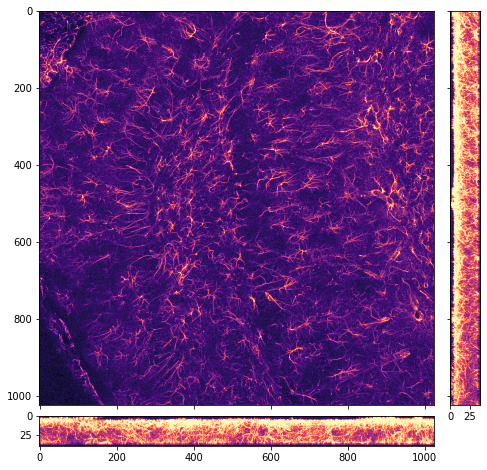

In [4]:
TISSUE_IMAGE = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_28 DAYS/control_28 days/CONTROL_MSP2.1MB_4_LONG MARK_20X_SEC 1_LEFT HILUS_28 DAYczi.czi'  #@param

################
# DO NOT TOUCH #
################
DECONV_ITR = 30

cache_dir = 'Cache/'
cached_filename = '.'.join(path.basename(TISSUE_IMAGE).split('.')[:-1]) + '.npy'
cached = False

original = ac.imread(TISSUE_IMAGE)
try:
  if cached_filename in listdir(cache_dir):
    deconvolved = np.load(cache_dir + cached_filename)
    cached = True
  else:
    raise ValueError('Preprocessed image not cached')
except:
  cached = False
  original = ac.imread(TISSUE_IMAGE)

  deconvolved = ac.deconvolve(original, TISSUE_IMAGE, iters=DECONV_ITR)

SCALE = None
try:
  if TISSUE_IMAGE.split('.')[-1] == 'czi':
    import czifile
    metadata = czifile.CziFile(TISSUE_IMAGE).metadata(False)['ImageDocument']['Metadata']
    dim_r = metadata['Scaling']['Items']['Distance'][0]['Value'] * 1e6
    dim_z = metadata['Scaling']['Items']['Distance'][-1]['Value'] * 1e6
    SCALE = (dim_z, dim_r, dim_r)
except:
  pass

# ac.projectXYZ(deconvolved, .5, .5, 1)
CLIP_LIMIT = .03

if cached:
  preprocessed = deconvolved
else:
  background = restoration.rolling_ball(deconvolved, radius=(min(deconvolved.shape)-1)//2)
  preprocessed = exposure.equalize_adapthist(deconvolved-background, clip_limit=CLIP_LIMIT)
ac.projectXYZ(preprocessed, .5, .5, 1, 'magma')

Contrast stretching -> CLAHE = Okay

CLAHE -> Rolling ball = Noisy

Deconv -> Rolling ball -> CLAHE = BEST

In [6]:
view_3D({'data': original, 'colormap': 'inferno', 'name': 'original'},
        {'data': preprocessed, 'colormap': 'inferno', 'name': 'preprocessed'})

---

## Step 2: Select ROI using Polygonal Lasso Tool

Set two variables:
- `SELECT_ROI`: True, If you want to select ROI manually; else False
- `NAME_ROI`: Name of the manually selected ROI
- `FILE_ROI`: Path to the ROI file; else None

In [5]:
SELECT_ROI = True
NAME_ROI = 'ML'
FILE_ROI = 'Datasets/Confocal/SAL,DMI, FLX ADN HALO_TREATMENT_28 DAYS/control_28 days/CONTROL_MSP2.1MB_4_LONG MARK_20X_SEC 1_LEFT HILUS_28 DAYczi_ML.roi'
roi_polygon = None
import matplotlib.pyplot as plt
%matplotlib widget

IMG_NAME = '.'.join(TISSUE_IMAGE.split('/')[-1].split('.')[:-1])

import matplotlib.pyplot as plt
file_roi_widget = widgets.Text(value=FILE_ROI, description='file_roi')
def roi_interact(select_roi=SELECT_ROI,
                 name_roi=NAME_ROI, draw_roi=False, file_roi=FILE_ROI):
  global SELECT_ROI, NAME_ROI, FILE_ROI, roi_polygon, file_roi_widget
  SELECT_ROI, NAME_ROI, FILE_ROI = select_roi, name_roi, file_roi
  NAME_ROI = NAME_ROI if SELECT_ROI else ''
  if draw_roi:
    FILE_ROI = None
    file_roi_widget.layout.visibility = 'hidden'
  else:
    file_roi_widget.value = FILE_ROI
    file_roi_widget.layout.visibility = 'visible'
    plt.clf()
  roi_polygon = np.array([[0, 0], [preprocessed.shape[0]-1, 0], [preprocessed.shape[0]-1, preprocessed.shape[1]-1], [0, preprocessed.shape[1]-1]]) if not SELECT_ROI else ac.select_ROI(preprocessed, IMG_NAME + '-' + NAME_ROI, FILE_ROI)


_ = widgets.interact(roi_interact, select_roi=SELECT_ROI,
                     name_roi=NAME_ROI, draw_roi=False, file_roi=file_roi_widget)

interactive(children=(Checkbox(value=True, description='select_roi'), Text(value='ML', description='name_roi')…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

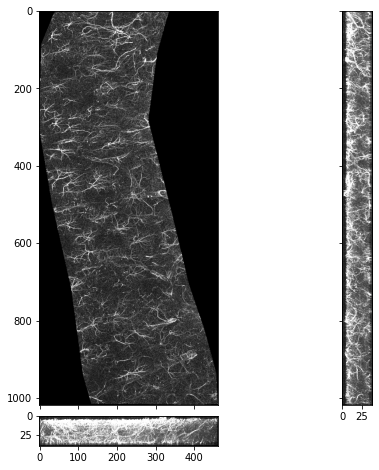

In [6]:
%matplotlib inline
if SELECT_ROI:
    original = ac.mask_ROI(original, roi_polygon)
    preprocessed = ac.mask_ROI(preprocessed, roi_polygon)
    ac.projectXYZ(preprocessed, .5, .5, 1)

In [7]:
# get the maximally inscribed rectangle
ll, ur = ac.get_maximal_rectangle([roi_polygon])

In [8]:
if SELECT_ROI:
  ll, ur = np.ceil(ll).astype(int), np.floor(ur).astype(int)
  llx, lly = ll; urx, ury = ur
  llx -= roi_polygon[:, 0].min(); urx -= roi_polygon[:, 0].min()
  lly -= roi_polygon[:, 1].min(); ury -= roi_polygon[:, 1].min()
else:
  lly = 0; llx = 0
  ury, urx = preprocessed.shape[1:]
  ury -= 1; urx -= 1
lly, llx, ury, urx

(90, 63, 577, 174)

In [9]:
denoise_parameters = ac.calibrate_nlm_denoiser(preprocessed[:, lly:ury, llx:urx])  # .13, .14
print(denoise_parameters)
denoised = ac.denoise(preprocessed, denoise_parameters)

import skimage
denoised = skimage.exposure.match_histograms(denoised, refdenoised)

{'h': 0.09594063588409912, 'patch_size': 4, 'patch_distance': 3}


In [25]:
view_3D({'data': original, 'colormap': 'gray_r', 'name': 'original'},
        {'data': preprocessed, 'colormap': 'gray_r', 'name': 'preprocessed'},
        {'data': denoised, 'colormap': 'gray_r', 'name': 'denoised'})

---

## Step 3: Segmentation

### 3.1 Global threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

Understand their effect by configuring three parameters:
- `LOW_DELTA`: Pixel intensity value corresponding to change in `LOW_THRESH`
- `HIGH_DELTA`: Pixel intensity value corresponding to change in `HIGH_THRESH`
- `N_STEPS`: Number of steps of delta in threshold to take in both directions

In [11]:
LOW_THRESH = .07  # .10 #.09
HIGH_THRESH = .12

LOW_DELTA = .01
HIGH_DELTA = .01
N_STEPS = 0
results = None

%matplotlib inline
def test_thresholds(low_thresh_init, low_thresh, high_thresh_init,
                    high_thresh, low_delta, high_delta, n_steps):
  global results, LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS
  LOW_THRESH, HIGH_THRESH, N_STEPS = low_thresh, high_thresh, n_steps
  if low_thresh_init is not None:
    LOW_THRESH = eval(f'skimage.filters.threshold_{low_thresh_init}(preprocesse[:, lly:ury, llx:urx])')
  if high_thresh_init is not None:
    if high_thresh_init == 'isodata':
      HIGH_THRESH = eval(f'skimage.filters.threshold_{high_thresh_init}(denoised[:, lly:ury, llx:urx])')
  LOW_DELTA, HIGH_DELTA = low_delta, high_delta
  results = ac.testThresholds(denoised, LOW_THRESH, HIGH_THRESH, LOW_DELTA,
                              HIGH_DELTA, N_STEPS, 'gist_earth')

if on_colab:
  _ = widgets.interact(test_thresholds,
                      low_thresh_init=[None, *sm.util.THRESHOLD_METHODS],
                      low_thresh=widgets.FloatSlider(LOW_THRESH, min=0, max=1, step=.01,
                                                      readout_format='.4f', layout=widgets.Layout(width='100%')),
                      high_thresh_init=[None, *sm.util.THRESHOLD_METHODS],
                      high_thresh=widgets.FloatSlider(HIGH_THRESH, min=0, max=1, step=.01,
                                                      readout_format='.4f', layout=widgets.Layout(width='100%')),
                      low_delta=widgets.FloatSlider(LOW_DELTA, min=0, max=1, step=.0005,
                                                    readout_format='.4f', layout=widgets.Layout(width='100%')),
                      high_delta=widgets.FloatSlider(HIGH_DELTA, min=0, max=1, step=.0005,
                                                      readout_format='.4f', layout=widgets.Layout(width='100%')),
                      n_steps=widgets.IntSlider(N_STEPS, min=0, max=10,
                                                layout=widgets.Layout(width='100%'))
  )
  # view_3D({'data': denoised, 'colormap': 'gray_r', 'name': 'denoised'}, *results)
else:
  viewer = napari.Viewer(ndisplay=3)
  viewer.add_image(denoised, scale=SCALE)
  @magicgui(
    call_button="Test Thresholds",
    low_auto_thresh={'choices': [None, *sm.util.THRESHOLD_METHODS]},
    low_thresh={"widget_type": "FloatSlider", 'max': 1},
    high_auto_thresh={'choices': [None, *sm.util.THRESHOLD_METHODS]},
    high_thresh={"widget_type": "FloatSlider", 'max': 1},
    low_delta={"widget_type": "FloatSlider", 'max': 1},
    high_delta={"widget_type": "FloatSlider", 'max': 1}
  )
  def test_thresholds_gui(
      low_auto_thresh=None,
      low_thresh=LOW_THRESH,
      high_auto_thresh=None,
      high_thresh=HIGH_THRESH,
      low_delta=LOW_DELTA,
      high_delta=HIGH_DELTA,
      n_steps=N_STEPS
  ):
    global results, LOW_THRESH, HIGH_THRESH, LOW_DELTA, HIGH_DELTA, N_STEPS
    LOW_THRESH, HIGH_THRESH, N_STEPS = low_thresh, high_thresh, n_steps
    if low_auto_thresh is not None:
      LOW_THRESH = eval(f'skimage.filters.threshold_{low_auto_thresh}(denoised[:, lly:ury, llx:urx])')
    if high_auto_thresh is not None:
      # if high_auto_init == 'isodata':
      HIGH_THRESH = eval(f'skimage.filters.threshold_{high_auto_thresh}(denoised[:, lly:ury, llx:urx])')
    LOW_DELTA, HIGH_DELTA = low_delta, high_delta
    results = ac.core._testThresholds(denoised, LOW_THRESH, HIGH_THRESH, LOW_DELTA,
                                      HIGH_DELTA, N_STEPS)
    past_state = viewer.window.qt_viewer.view.camera.get_state()
    viewer.layers.clear()

    viewer.add_image(denoised, scale=SCALE)

    n_images = len(results)
    for itr in range(n_images):
      viewer.add_labels(**results[itr], scale=SCALE)
    viewer.window.qt_viewer.view.camera.set_state(past_state)

  viewer.window.add_dock_widget(test_thresholds_gui)
  test_thresholds_gui()

In [12]:
print(LOW_THRESH, HIGH_THRESH)
thresholded = ac.threshold(denoised, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)

prefiltering_volume = thresholded.sum()
f'Prefiltering Volume: {prefiltering_volume}'

0.07 0.12


'Prefiltering Volume: 254518'

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

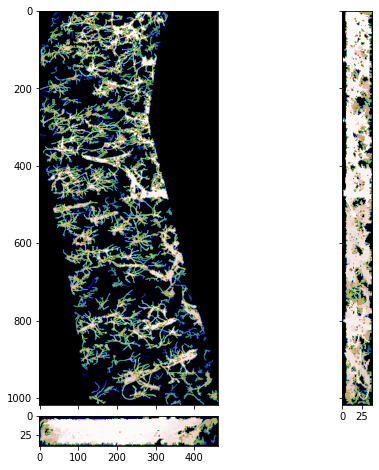

In [13]:
# discard objects connected to border of approximated tissue, potential partially captured
# filtered_labels = ac.filter_labels(labels, thresholded, roi_polygon) if original.shape[0] > 1 else labels
filtered_labels = labels

# get the centroids and label values from the label image
regions = ac.arrange_regions(filtered_labels)
# regions = sorted(regions, key= lambda r: [r.centroid[2], r.centroid[1], r.centroid[0]])

centroid_coords = [r['centroid'] for r in regions]

# store the labels for each blob in a properties dictionary
pts_properties = {'obj': [i for i in range(len(regions))]}


# reconstruct despeckled filtered_labels
filtered_labels = np.zeros_like(filtered_labels, dtype=int)

reg_itr = 1

for region in regions:
    minz, miny, minx, maxz, maxy, maxx = region['bbox']
    filtered_labels[minz:maxz, miny:maxy, minx:maxx] += region['image'] * reg_itr
    reg_itr += 1

segmented = denoised * (filtered_labels > 0)

ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [20]:
view_3D({'data': segmented, 'colormap': 'inferno', 'name': 'segmented'},
        {'data': filtered_labels, 'colormap': 'gray', 'gamma': .8, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'gamma': .8, 'name': 'labels'})

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check segmented cells on whole image

In [19]:
PRE_LOW_VOLUME_CUTOFF = 500  # filter noise/artifacts

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(denoised, scale=SCALE)
viewer.add_labels(filtered_labels, rendering='translucent', opacity=.5, scale=SCALE)

region_props = PyQt5.QtWidgets.QLabel()
region_inclusivity = np.ones(len(regions), dtype=bool)
REGION_INCLUSIVITY_LABELS = ['Include Region', 'Exclude Region']

n_region = 0
PROPS = ['vol',
# 'convex_area',
# 'equivalent_diameter',
# 'euler_number',
# 'extent',
# 'feret_diameter_max',
# 'major_axis_length',
# 'minor_axis_length',
# 'solidity'
]

@magicgui(
  call_button='Exclude regions by volume',
  cutoff={'widget_type': 'Slider', 'max': regions[-1]['vol']}
)
def vol_cutoff_update(
  cutoff=PRE_LOW_VOLUME_CUTOFF
):
  global filtered_labels, regions, segmented, PRE_LOW_VOLUME_CUTOFF
  layer_names = [layer.name for layer in viewer.layers]
  PRE_LOW_VOLUME_CUTOFF = cutoff
  filtered_labels.fill(0)
  itr = 1
  filtered_regions = []
  for region in regions:
    if cutoff <= region['vol']:
      minz, miny, minx, maxz, maxy, maxx = region['bbox']
      filtered_labels[minz:maxz, miny:maxy, minx:maxx] += region['image'] * itr
      itr += 1
      filtered_regions.append(region)
  viewer.layers[layer_names.index('filtered_labels')].data = filtered_labels
  regions = filtered_regions
  segmented = denoised * (filtered_labels > 0)
  select_region()

@magicgui(
  auto_call=True,
  selected_region={'maximum': len(regions)-1},
  select_region=dict(widget_type='PushButton', text='Select Region')
)
def select_region(
  selected_region=n_region,
  select_region=True  # just for activating the method
):
  global n_region
  n_region = selected_region
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  centroid = regions[n_region]['centroid']
  if SCALE is not None:
    centroid = centroid * np.array(SCALE)
    minz *= SCALE[0]; maxz *= SCALE[0]
    miny *= SCALE[1]; maxy *= SCALE[1]
    minx *= SCALE[2]; maxx *= SCALE[2]

  if viewer.dims.ndisplay == 3:
    viewer.camera.center = centroid
  elif viewer.dims.ndisplay == 2:
    viewer.dims.set_current_step(0, round(centroid[0]))
    viewer.window.qt_viewer.view.camera.set_state({'rect': Rect(minx, miny, maxx-minx, maxy-miny)})

  data = '<table cellspacing="8">'
  for prop in PROPS:
    name = prop
    data += '<tr><td><b>' + name + '</b></td><td>' + str(eval(f'regions[{n_region}]["{prop}"]')) + '</td></tr>'
  data += '</table>'
  region_props.setText(data)


viewer.window.add_dock_widget(vol_cutoff_update, name='Volume Cutoff', area='bottom')
viewer.window._dock_widgets['Volume Cutoff'].setFixedHeight(90)
viewer.window.add_dock_widget(select_region, name='Select Region')
viewer.window._dock_widgets['Select Region'].setFixedHeight(100)
viewer.window.add_dock_widget(region_props, name='Region Properties')
viewer.window._dock_widgets['Select Region'].setFixedHeight(270)
select_region()

In [20]:
somas_estimates = ac.approximate_somas(segmented, regions,
load='Autocropped/CONTROL_MSP2.1MB_4_LONG MARK_20X_SEC 1_LEFT HILUS_28 DAYczi-ML/.somas_estimates.npy')
len(somas_estimates)

243

In [21]:
regions = sorted(regions, key=lambda region: region['vol'])
# areas = [region['vol'] for region in regions]
reconstructed_labels = np.zeros(denoised.shape, dtype=int)
for itr in range(len(regions)):
    minz, miny, minx, maxz, maxy, maxx = regions[itr]['bbox']
    reconstructed_labels[minz:maxz, miny:maxy, minx:maxx] += regions[itr]['image'] * (itr + 1)

# centroid_coords = [r['centroid'] for r in regions]

# store the labels for each blob in a properties dictionary
# pts_properties = {'obj': [i for i in range(len(regions))]}

# if not on_colab:
#     with napari.gui_qt():
#         man_viewer = napari.view_image(segmented, ndisplay=3, colormap='inferno')
#         man_viewer.add_labels(reconstructed_labels, rendering='translucent', opacity=.5, scale=SCALE)
#         man_viewer.add_points(somas_estimates, face_color='red', edge_color='transparent', size=5, scale=SCALE)
#         # , properties=pts_properties, text='obj')

# napari clump sep

In [22]:
ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES = None, None

In [23]:
region_props = PyQt5.QtWidgets.QLabel()
region_inclusivity = np.ones(len(regions), dtype=bool)
REGION_INCLUSIVITY_LABELS = ['Include Region', 'Exclude Region']
filtered_regions = None
n_region = 0

PROPS = ['vol',
# 'convex_area',
# 'equivalent_diameter',
# 'euler_number',
# 'extent',
# 'feret_diameter_max',
# 'major_axis_length',
# 'minor_axis_length',
# 'solidity'
]

@magicgui(
  auto_call=True,
  selected_region={'maximum': len(regions)-1},
  select_region=dict(widget_type='PushButton', text='Select Region')
)
def select_region(
  selected_region=n_region,
  select_region=True  # pseudo: just for activating the method
):
  global n_region
  n_region = selected_region
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  centroid = regions[n_region]['centroid']
  if SCALE is not None:
    centroid = centroid * np.array(SCALE)
    minz *= SCALE[0]; maxz *= SCALE[0]
    miny *= SCALE[1]; maxy *= SCALE[1]
    minx *= SCALE[2]; maxx *= SCALE[2]
  if viewer.dims.ndisplay == 3:
    viewer.camera.center = centroid
  elif viewer.dims.ndisplay == 2:
    viewer.dims.set_current_step(0, round(centroid[0]))
    viewer.window.qt_viewer.view.camera.set_state({'rect': Rect(minx, miny, maxx-minx, maxy-miny)})

  data = '<table cellspacing="8">'
  data += '<tr><td><b>included</b></td><td>' + str(region_inclusivity[n_region]) + '</td></tr>'
  for prop in PROPS:
    name = prop
    data += '<tr><td><b>' + name + '</b></td><td>' + str(eval(f'regions[{n_region}]["{prop}"]')) + '</td></tr>'
  data += '</table>'
  region_props.setText(data)
  viewer.window._dock_widgets['Region Inclusivity'].children(
  )[4].children()[1].setText(REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]])


@magicgui(
  call_button=REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]]
)
def exclude_region():
  global region_inclusivity, region_props
  region_inclusivity[n_region] = ~region_inclusivity[n_region]
  data = '<table cellspacing="8">'
  data += '<tr><td><b>included</b></td><td>' + str(region_inclusivity[n_region]) + '</td></tr>'
  for prop in PROPS:
    name = prop
    data += '<tr><td><b>' + name + '</b></td><td>' + str(eval(f'regions[{n_region}]["{prop}"]')) + '</td></tr>'
  data += '</table>'
  region_props.setText(data)
  viewer.window._dock_widgets['Region Inclusivity'].children(
  )[4].children()[1].setText(REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]])


@magicgui(
  call_button="Use soma_coord approximation"
)
def interactive_segment1():
  layer_names = [layer.name for layer in viewer.layers]
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  ll = np.array([minz, miny, minx])
  ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
  inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
  somas_coords = np.array(somas_estimates)[inidx]
  somas_coords -= ll
  somas_coords = np.array([x for x in somas_coords if regions[n_region]['image'][tuple(x.astype(np.int64))] > 0])
  labels = skimage.measure.label(regions[n_region]['image'])
  areg = []
  for coord in somas_coords:
    areg.append(labels[tuple(coord.astype(np.int64))])
  visited = []
  filtered_coords = []
  for i in range(len(areg)):
    if areg[i] not in visited:
      filtered_coords.append(somas_coords[i])
      visited.append(areg[i])
  filtered_coords = np.array(filtered_coords)

  if 'filtered_coords' in layer_names:
    data = viewer.layers[layer_names.index('filtered_coords')].data
    for coord in filtered_coords:
      if ~(data == coord).all(axis=1).any():
        viewer.layers[layer_names.index('filtered_coords')].add(np.round_(coord + ll).astype(np.int64))
  else:
    viewer.add_points(filtered_coords + ll, face_color='red', edge_width=0,
                      opacity=.6, size=5, name='filtered_coords', scale=SCALE)


@magicgui(
  call_button="Watershed region coords",
  hyst_thresh={'widget_type': 'FloatSlider', 'max': 1}
)
def interactive_segment2(
  hyst_thresh=0  # add button for use as is
):
  layer_names = [layer.name for layer in viewer.layers]
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  ll = np.array([minz, miny, minx])
  ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
  inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
  somas_coords = np.array(somas_estimates)[inidx]
  somas_coords -= ll
  somas_coords = np.array([x for x in somas_coords if regions[n_region]['image'][tuple(x.astype(np.int64))] > 0])
  clump = segmented[minz:maxz, miny:maxy, minx:maxx] * regions[n_region]['image']
  # hyst_thresh_ptile = np.percentile(clump[clump > 0].ravel(), hyst_thresh * 100)
  threshed = clump > hyst_thresh
  labels = skimage.measure.label(threshed)
  areg = []
  for coord in somas_coords:
    areg.append(labels[tuple(coord.astype(np.int64))])
  visited = []
  filtered_coords = []
  for i in range(len(areg)):
    if areg[i] not in visited:
      filtered_coords.append(somas_coords[i])
      visited.append(areg[i])
  filtered_coords = np.array(filtered_coords)

  if 'filtered_coords' in layer_names:
    data = viewer.layers[layer_names.index('filtered_coords')].data
    for coord in filtered_coords:
      coord_to_add = np.round_(coord + ll).astype(np.int64)
      #TODO: remove extra pts: Clump > 0 ko invert krke mask mai multiply kro aur fir wapis coord mai convert kro
      if ~(data == coord_to_add).all(axis=1).any():
        viewer.layers[layer_names.index('filtered_coords')].add(coord_to_add)
  else:
    viewer.add_points(filtered_coords + ll, face_color='red', edge_width=0,
                      opacity=.6, size=5, name='filtered_coords', scale=SCALE)


@magicgui(
  call_button='Watershed regions'
)
def clump_separation_napari():
  global filtered_regions
  SEARCH_LAYER = 'filtered_coords'
  layer_names = [layer.name for layer in viewer.layers]
  somas_estimates = np.unique(viewer.layers[layer_names.index(SEARCH_LAYER)].data, axis=0)
  filtered_regions, residue = [], []
  separated_clumps = []

  print('Please recheck if you REALLY want these changes.')
  itr = 0
  for region in regions:
    minz, miny, minx, maxz, maxy, maxx = region['bbox']
    ll = np.array([minz, miny, minx])  # lower-left
    ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
    inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
    somas_coords = somas_estimates[inidx].astype(np.int64)

    if len(somas_coords) == 0:
      print('Delete region:', itr)
      residue.append(region)
    elif len(np.unique(somas_coords.astype(int), axis=0)) > 1:  # clumpSep
      somas_coords = somas_coords.astype(int)
      somas_coords -= ll
      im = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
      im[~region['image']] = 0
      markers = np.zeros(region['image'].shape)

      somas_coords = np.array([x for x in somas_coords if region['image'][tuple(x)] > 0])

      if len(somas_coords) == 0:  # no marked point ROI
        print('Delete region:', itr)

      if somas_coords.shape[0] == 1:
        filtered_regions.append(region)
        continue

      for i in range(somas_coords.shape[0]):
        markers[tuple(somas_coords[i])] = i + 1
        separated_clumps.append(somas_coords[i])

      labels = _segment_clump(im, markers)
      separated_regions = ac.core.arrange_regions(labels)
      for r in separated_regions:
        r['centroid'] = (minz + r['centroid'][0], miny + r['centroid'][1], minx + r['centroid'][2])
        r['bbox'] = (minz + r['bbox'][0], miny + r['bbox'][1], minx + r['bbox'][2], minz + r['bbox'][3], miny + r['bbox'][4], minx + r['bbox'][5])
        # r.slice = (slice(minz + r.bbox[0], minz + r.bbox[3]),
        #            slice(miny + r.bbox[1], miny + r.bbox[4]),
        #         slice(minx + r.bbox[2], minx + r.bbox[5]))
      print('Split clump region:', itr)
      filtered_regions.extend(separated_regions)
    else:
      filtered_regions.append(region)
    itr += 1

  watershed_results = np.zeros(denoised.shape, dtype=int)
  for itr in range(len(filtered_regions)):
      minz, miny, minx, maxz, maxy, maxx = filtered_regions[itr]['bbox']
      watershed_results[minz:maxz, miny:maxy, minx:maxx] += filtered_regions[itr]['image'] * (itr + 1)
  viewer.add_labels(watershed_results, rendering='translucent', opacity=.5, scale=SCALE)


@magicgui(
  call_button="Confirm and apply changes"
)
def save_watershed():
  global regions, ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES
  layer_names = [layer.name for layer in viewer.layers]
  viewer.layers.remove('watershed_results')
  regions = sorted(filtered_regions, key=lambda region: region['vol'])
  watershed_results = np.zeros(denoised.shape, dtype=int)
  for itr in range(len(regions)):
      minz, miny, minx, maxz, maxy, maxx = regions[itr]['bbox']
      watershed_results[minz:maxz, miny:maxy, minx:maxx] += regions[itr]['image'] * (itr + 1)
  if 'reconstructed_labels' in layer_names:
    viewer.layers[layer_names.index('reconstructed_labels')].data = watershed_results

  # After all changes (for reproducibility)
  final_soma = np.unique(viewer.layers[layer_names.index('filtered_coords')].data, axis=0)

  # discarded clump ROI: to be subtracted: np.setdiff1d(somas_estimates, final_soma)
  ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES = somas_estimates.copy(), final_soma


viewer = napari.Viewer(ndisplay=3)
# minz, miny, minx, maxz, maxy, maxx = region['bbox']
viewer.add_image(denoised, scale=SCALE)
viewer.add_image(segmented, scale=SCALE)
viewer.add_labels(reconstructed_labels, rendering='translucent', opacity=.5, scale=SCALE)
viewer.add_points(somas_estimates, face_color='orange', edge_width=0,
                  opacity=.6, size=5, name='somas_coords', scale=SCALE)
# viewer.add_points(FINAL_PT_ESTIMATES, face_color='red',
#                   edge_width=0, opacity=.6, size=5, name='filtered_coords', scale=SCALE)
viewer.add_points(np.load('Autocropped/CONTROL_MSP2.1MB_4_LONG MARK_20X_SEC 1_LEFT HILUS_28 DAYczi-ML/.somas_estimates.npy', allow_pickle=True)[1].astype(int), face_color='red',
                  edge_width=0, opacity=.6, size=5, name='filtered_coords', scale=SCALE)

viewer.window.add_dock_widget(select_region, name='Select Region')
viewer.window._dock_widgets['Select Region'].setFixedHeight(100)
viewer.window.add_dock_widget(region_props, name='Region Properties')
viewer.window._dock_widgets['Region Properties'].setFixedHeight(270)
viewer.window.add_dock_widget(exclude_region, name='Region Inclusivity')
viewer.window._dock_widgets['Region Inclusivity'].setFixedHeight(70)
viewer.window.add_dock_widget(interactive_segment1, name='Interactive Segmentation 1')
viewer.window._dock_widgets['Interactive Segmentation 1'].setFixedHeight(70)
viewer.window.add_dock_widget(interactive_segment2, name='Interactive Segmentation 2')
viewer.window._dock_widgets['Interactive Segmentation 2'].setFixedWidth(350)
viewer.window._dock_widgets['Interactive Segmentation 2'].setFixedHeight(100)
viewer.window.add_dock_widget(clump_separation_napari, name='Clump Separation')
viewer.window._dock_widgets['Clump Separation'].setFixedHeight(70)
viewer.window.add_dock_widget(save_watershed, name='Confirm Changes')
viewer.window._dock_widgets['Confirm Changes'].setFixedHeight(70)

select_region()

In [ ]:
# np.save('tmp_filtered_coords_CTL.npy', viewer.layers[-1].data)

In [ ]:
# Reproduce (reload)
# somas_estimates = np.vstack((somas_estimates, np.load('rejected_clumps-ML.npy')))

In [33]:
reconstructed_labels = np.zeros(denoised.shape, dtype=int)
for itr in range(len(regions)):
    minz, miny, minx, maxz, maxy, maxx = regions[itr]['bbox']
    reconstructed_labels[minz:maxz, miny:maxy, minx:maxx] += regions[itr]['image'] * (itr + 1)
segmented = denoised * (reconstructed_labels > 0)
# discard objects connected to border of approximated tissue, potential partially captured
# filtered_labels = ac.filter_labels(reconstructed_labels, thresholded, roi_polygon) if original.shape[0] > 1 else labels
# regions = ac.arrange_regions(filtered_labels)
len(regions)

188

#### 3.3.2: Check batches of objects

In [34]:
# Set `BATCH_NO` to view detected objects in paginated 2D MIP views.
N_BATCHES = ac.paginate_objs(regions, pg_size=50)

def plot_batch(BATCH_NO):
  ac.project_batch(BATCH_NO, N_BATCHES, regions, denoised)
  plt.show()

_ = widgets.interact(plot_batch, BATCH_NO=widgets.IntSlider(min=0,
                       max=N_BATCHES-1, layout=widgets.Layout(width='100%')))

188 objects detected.
There will be 4 batches, set `BATCH_NO` from 0 to 3 inclusive


interactive(children=(IntSlider(value=0, description='BATCH_NO', layout=Layout(width='100%'), max=3), Output()…

#### 3.3.2: Check individual objects
Select individual objects using `OBJ_INDEX`.

In [35]:
OBJ_INDEX = 0
extracted_cell = None
minz, miny, minx, maxz, maxy, maxx = 0, 0, 0, 0, 0, 0

def plot_single(obj_index):
  global OBJ_INDEX, extracted_cell, minz, miny, minx, maxz, maxy, maxx
  OBJ_INDEX = obj_index
  extracted_cell = ac.extract_obj(regions[OBJ_INDEX], segmented)
  minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX]['bbox']
  ac.projectXYZ(extracted_cell, .5, .5, 1)

if on_colab:
  _ = widgets.interact(plot_single, obj_index=widgets.IntSlider(min=0,
                        max=len(regions)-1, layout=widgets.Layout(width='100%')))
else:
  viewer = napari.Viewer(ndisplay=3)

  @magicgui(
    auto_call=True,
    selected_region={'maximum': len(regions)-1}
  )
  def view_single_region(selected_region=0):
    global n_region
    n_region = selected_region
    somas_estimates = FINAL_PT_ESTIMATES
    minz, miny, minx, maxz, maxy, maxx = regions[selected_region]['bbox']
    extracted_cell = denoised[minz:maxz, miny:maxy, minx:maxx]*regions[selected_region]['image']
    ll = np.array([minz, miny, minx])
    ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
    inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
    somas_coords = np.array(somas_estimates)[inidx]
    somas_coords -= ll
    somas_coords = np.array([x for x in somas_coords if regions[n_region]['image'][tuple(x.astype(np.int64))] > 0])
    labels = skimage.measure.label(regions[n_region]['image'])
    areg = []
    for coord in somas_coords:
      areg.append(labels[tuple(coord.astype(np.int64))])
    visited = []
    filtered_coords = []
    for i in range(len(areg)):
      if areg[i] not in visited:
        filtered_coords.append(somas_coords[i])
        visited.append(areg[i])
    filtered_coords = np.array(filtered_coords)

    if len(viewer.layers) == 0:
      viewer.add_image(denoised[minz:maxz, miny:maxy, minx:maxx], name='denoised', colormap='red', scale=SCALE)
      viewer.add_image(denoised[minz:maxz, miny:maxy, minx:maxx]*regions[selected_region]['image'], name='segmented', colormap='red', scale=SCALE)
      viewer.add_points(filtered_coords, face_color='lime', edge_width=0,
                        opacity=.6, size=5, name='filtered_coords', scale=SCALE)
    else:
      viewer.layers[0].data = denoised[minz:maxz, miny:maxy, minx:maxx]
      viewer.layers[1].data = extracted_cell
      viewer.layers[2].data = filtered_coords
    viewer.camera.center = ((maxz-minz)//2, (maxy-miny)//2, (maxx-minx)//2)

  @magicgui(
    call_button="Update soma estimates"
  )
  def update_soma_estimates():
    global FINAL_PT_ESTIMATES
    layer_names = [layer.name for layer in viewer.layers]
    region = regions[n_region]
    minz, miny, minx, maxz, maxy, maxx = region['bbox']
    ll = np.array([minz, miny, minx])
    somas_coords = viewer.layers[layer_names.index('filtered_coords')].data.astype(int)
    im = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
    im[~region['image']] = 0
    markers = np.zeros(region['image'].shape)

    for i in range(somas_coords.shape[0]):
      markers[tuple(somas_coords[i])] = i + 1

    labels = _segment_clump(im, markers)
    viewer.add_labels(labels, rendering='translucent', opacity=.5, scale=SCALE)
    FINAL_PT_ESTIMATES = np.vstack((FINAL_PT_ESTIMATES, somas_coords+ll))
    FINAL_PT_ESTIMATES = np.unique(FINAL_PT_ESTIMATES, axis=0)

  viewer.window.add_dock_widget(view_single_region, name='View individual region')
  viewer.window._dock_widgets['View individual region'].setFixedHeight(70)
  viewer.window.add_dock_widget(update_soma_estimates, name='Update soma estimates')
  view_single_region()

In [32]:
region_props = PyQt5.QtWidgets.QLabel()
region_inclusivity = np.ones(len(regions), dtype=bool)
REGION_INCLUSIVITY_LABELS = ['Include Region', 'Exclude Region']
filtered_regions = None
n_region = 0
PROPS = ['vol',
# 'convex_area',
# 'equivalent_diameter',
# 'euler_number',
# 'extent',
# 'feret_diameter_max',
# 'major_axis_length',
# 'minor_axis_length',
# 'solidity'
]

@magicgui(
  auto_call=True,
  selected_region={'maximum': len(regions)-1},
  select_region=dict(widget_type='PushButton', text='Select Region')
)
def select_region(
  selected_region=n_region,
  select_region=True  # pseudo: just for activating the method
):
  global n_region
  n_region = selected_region
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  centroid = regions[n_region]['centroid']
  if SCALE is not None:
    centroid = centroid * np.array(SCALE)
    minz *= SCALE[0]; maxz *= SCALE[0]
    miny *= SCALE[1]; maxy *= SCALE[1]
    minx *= SCALE[2]; maxx *= SCALE[2]
  if viewer.dims.ndisplay == 3:
    viewer.camera.center = centroid
  elif viewer.dims.ndisplay == 2:
    viewer.dims.set_current_step(0, round(centroid[0]))
    viewer.window.qt_viewer.view.camera.set_state({'rect': Rect(minx, miny, maxx-minx, maxy-miny)})

  data = '<table cellspacing="8">'
  data += '<tr><td><b>included</b></td><td>' + str(region_inclusivity[n_region]) + '</td></tr>'
  for prop in PROPS:
    name = prop
    data += '<tr><td><b>' + name + '</b></td><td>' + str(eval(f'regions[{n_region}]["{prop}"]')) + '</td></tr>'
  data += '</table>'
  region_props.setText(data)
  viewer.window._dock_widgets['Region Inclusivity'].children(
  )[4].children()[1].setText(REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]])


@magicgui(
  call_button=REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]]
)
def exclude_region():
  global region_inclusivity, region_props
  region_inclusivity[n_region] = ~region_inclusivity[n_region]
  data = '<table cellspacing="8">'
  data += '<tr><td><b>included</b></td><td>' + str(region_inclusivity[n_region]) + '</td></tr>'
  for prop in PROPS:
    name = prop
    data += '<tr><td><b>' + name + '</b></td><td>' + str(eval(f'regions[{n_region}]["{prop}"]')) + '</td></tr>'
  data += '</table>'
  region_props.setText(data)
  viewer.window._dock_widgets['Region Inclusivity'].children(
  )[4].children()[1].setText(REGION_INCLUSIVITY_LABELS[region_inclusivity[n_region]])


@magicgui(
  call_button="Use soma_coord approximation"
)
def interactive_segment1():
  layer_names = [layer.name for layer in viewer.layers]
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  ll = np.array([minz, miny, minx])
  ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
  inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
  somas_coords = np.array(somas_estimates)[inidx]
  somas_coords -= ll
  somas_coords = np.array([x for x in somas_coords if regions[n_region]['image'][tuple(x.astype(np.int64))] > 0])
  labels = skimage.measure.label(regions[n_region]['image'])
  areg = []
  for coord in somas_coords:
    areg.append(labels[tuple(coord.astype(np.int64))])
  visited = []
  filtered_coords = []
  for i in range(len(areg)):
    if areg[i] not in visited:
      filtered_coords.append(somas_coords[i])
      visited.append(areg[i])
  filtered_coords = np.array(filtered_coords)

  if 'filtered_coords' in layer_names:
    data = viewer.layers[layer_names.index('filtered_coords')].data
    for coord in filtered_coords:
      if ~(data == coord).all(axis=1).any():
        viewer.layers[layer_names.index('filtered_coords')].add(np.round_(coord + ll).astype(np.int64))
  else:
    viewer.add_points(filtered_coords + ll, face_color='red', edge_width=0,
                      opacity=.6, size=5, name='filtered_coords', scale=SCALE)


@magicgui(
  call_button="Watershed region coords",
  hyst_thresh={'widget_type': 'FloatSlider', 'max': 1}
)
def interactive_segment2(
  hyst_thresh=0  # add button for use as is
):
  layer_names = [layer.name for layer in viewer.layers]
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  ll = np.array([minz, miny, minx])
  ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
  inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
  somas_coords = np.array(somas_estimates)[inidx]
  somas_coords -= ll
  somas_coords = np.array([x for x in somas_coords if regions[n_region]['image'][tuple(x.astype(np.int64))] > 0])
  clump = segmented[minz:maxz, miny:maxy, minx:maxx] * regions[n_region]['image']
  # hyst_thresh_ptile = np.percentile(clump[clump > 0].ravel(), hyst_thresh * 100)
  threshed = clump > hyst_thresh
  labels = skimage.measure.label(threshed)
  areg = []
  for coord in somas_coords:
    areg.append(labels[tuple(coord.astype(np.int64))])
  visited = []
  filtered_coords = []
  for i in range(len(areg)):
    if areg[i] not in visited:
      filtered_coords.append(somas_coords[i])
      visited.append(areg[i])
  filtered_coords = np.array(filtered_coords)

  if 'filtered_coords' in layer_names:
    data = viewer.layers[layer_names.index('filtered_coords')].data
    for coord in filtered_coords:
      coord_to_add = np.round_(coord + ll).astype(np.int64)
      #TODO: remove extra pts: Clump > 0 ko invert krke mask mai multiply kro aur fir wapis coord mai convert kro
      if ~(data == coord_to_add).all(axis=1).any():
        viewer.layers[layer_names.index('filtered_coords')].add(coord_to_add)
  else:
    viewer.add_points(filtered_coords + ll, face_color='red', edge_width=0,
                      opacity=.6, size=5, name='filtered_coords', scale=SCALE)


@magicgui(
  call_button='Watershed regions'
)
def clump_separation_napari():
  global filtered_regions
  SEARCH_LAYER = 'filtered_coords'
  layer_names = [layer.name for layer in viewer.layers]
  somas_estimates = np.unique(viewer.layers[layer_names.index(SEARCH_LAYER)].data, axis=0)
  filtered_regions, residue = [], []
  separated_clumps = []

  print('Please recheck if you REALLY want these changes.')
  itr = 0
  for region in regions:
    minz, miny, minx, maxz, maxy, maxx = region['bbox']
    ll = np.array([minz, miny, minx])  # lower-left
    ur = np.array([maxz, maxy, maxx]) - 1  # upper-right
    inidx = np.all(np.logical_and(ll <= somas_estimates, somas_estimates <= ur), axis=1)
    somas_coords = somas_estimates[inidx].astype(np.int64)

    if len(somas_coords) == 0:
      print('Delete region:', itr)
      residue.append(region)
    elif len(np.unique(somas_coords.astype(int), axis=0)) > 1:  # clumpSep
      somas_coords = somas_coords.astype(int)
      somas_coords -= ll
      im = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
      im[~region['image']] = 0
      markers = np.zeros(region['image'].shape)

      somas_coords = np.array([x for x in somas_coords if region['image'][tuple(x)] > 0])

      if len(somas_coords) == 0:  # no marked point ROI
        print('Delete region:', itr)

      if somas_coords.shape[0] == 1:
        filtered_regions.append(region)
        continue

      for i in range(somas_coords.shape[0]):
        markers[tuple(somas_coords[i])] = i + 1
        separated_clumps.append(somas_coords[i])

      labels = _segment_clump(im, markers)
      separated_regions = ac.core.arrange_regions(labels)
      for r in separated_regions:
        r['centroid'] = (minz + r['centroid'][0], miny + r['centroid'][1], minx + r['centroid'][2])
        r['bbox'] = (minz + r['bbox'][0], miny + r['bbox'][1], minx + r['bbox'][2], minz + r['bbox'][3], miny + r['bbox'][4], minx + r['bbox'][5])
        # r.slice = (slice(minz + r.bbox[0], minz + r.bbox[3]),
        #            slice(miny + r.bbox[1], miny + r.bbox[4]),
        #         slice(minx + r.bbox[2], minx + r.bbox[5]))
      print('Split clump region:', itr)
      filtered_regions.extend(separated_regions)
    else:
      filtered_regions.append(region)
    itr += 1

  watershed_results = np.zeros(denoised.shape, dtype=int)
  for itr in range(len(filtered_regions)):
      minz, miny, minx, maxz, maxy, maxx = filtered_regions[itr]['bbox']
      watershed_results[minz:maxz, miny:maxy, minx:maxx] += filtered_regions[itr]['image'] * (itr + 1)
  viewer.add_labels(watershed_results, rendering='translucent', opacity=.5, scale=SCALE)


@magicgui(
  call_button="Confirm and apply changes"
)
def save_watershed():
  global regions, ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES
  layer_names = [layer.name for layer in viewer.layers]
  viewer.layers.remove('watershed_results')
  regions = sorted(filtered_regions, key=lambda region: region['vol'])
  watershed_results = np.zeros(denoised.shape, dtype=int)
  for itr in range(len(regions)):
      minz, miny, minx, maxz, maxy, maxx = regions[itr]['bbox']
      watershed_results[minz:maxz, miny:maxy, minx:maxx] += regions[itr]['image'] * (itr + 1)
  if 'reconstructed_labels' in layer_names:
    viewer.layers[layer_names.index('reconstructed_labels')].data = watershed_results

  # After all changes (for reproducibility)
  final_soma = np.unique(viewer.layers[layer_names.index('filtered_coords')].data, axis=0)

  # discarded clump ROI: to be subtracted: np.setdiff1d(somas_estimates, final_soma)
  ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES = somas_estimates.copy(), final_soma


viewer = napari.Viewer(ndisplay=3)
minz, miny, minx, maxz, maxy, maxx = region['bbox']
viewer.add_image(denoised, scale=SCALE)
viewer.add_image(segmented, scale=SCALE)
viewer.add_labels(reconstructed_labels, rendering='translucent', opacity=.5, scale=SCALE)
viewer.add_points(somas_estimates, face_color='orange', edge_width=0,
                  opacity=.6, size=5, name='somas_coords', scale=SCALE)
viewer.add_points(FINAL_PT_ESTIMATES, face_color='red',
                  edge_width=0, opacity=.6, size=5, name='filtered_coords', scale=SCALE)

viewer.window.add_dock_widget(select_region, name='Select Region')
viewer.window._dock_widgets['Select Region'].setFixedHeight(100)
viewer.window.add_dock_widget(region_props, name='Region Properties')
viewer.window._dock_widgets['Region Properties'].setFixedHeight(270)
viewer.window.add_dock_widget(exclude_region, name='Region Inclusivity')
viewer.window._dock_widgets['Region Inclusivity'].setFixedHeight(70)
viewer.window.add_dock_widget(interactive_segment1, name='Interactive Segmentation 1')
viewer.window._dock_widgets['Interactive Segmentation 1'].setFixedHeight(70)
viewer.window.add_dock_widget(interactive_segment2, name='Interactive Segmentation 2')
viewer.window._dock_widgets['Interactive Segmentation 2'].setFixedWidth(350)
viewer.window._dock_widgets['Interactive Segmentation 2'].setFixedHeight(100)
viewer.window.add_dock_widget(clump_separation_napari, name='Clump Separation')
viewer.window._dock_widgets['Clump Separation'].setFixedHeight(70)
viewer.window.add_dock_widget(save_watershed, name='Confirm Changes')
viewer.window._dock_widgets['Confirm Changes'].setFixedHeight(70)

select_region()

In [ ]:
# np.save('tmp_filtered_coords_CTL.npy', viewer.layers[-1].data)
# reconstructed_labels = np.zeros(denoised.shape, dtype=int)
# for itr in range(len(regions)):
#     minz, miny, minx, maxz, maxy, maxx = regions[itr]['bbox']
#     reconstructed_labels[minz:maxz, miny:maxy, minx:maxx] += regions[itr]['image'] * (itr + 1)
# segmented = denoised * (reconstructed_labels > 0)
# len(regions)

---

## Step 4: Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = '3d' for 3D cells, or
- Set `OUTPUT_OPTION` = 'mip' for Max Intensity Projections.

In [ ]:
LOW_VOLUME_CUTOFF = regions[0]['vol']  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = regions[-1]['vol']  # filter cell clusters
OUTPUT_OPTION = 'both'  # '3d' for 3D cells, 'mip' for Max Intensity Projections
SEGMENT_TYPE = 'both'
reconstructed_cells = None


def volume_range(low_volume_cutoff=LOW_VOLUME_CUTOFF,
                 high_volume_cutoff=HIGH_VOLUME_CUTOFF, output_option=OUTPUT_OPTION,
                 segment_type=SEGMENT_TYPE):
  global LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, SEGMENT_TYPE, reconstructed_cells
  LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF = low_volume_cutoff, high_volume_cutoff
  OUTPUT_OPTION, SEGMENT_TYPE = output_option, segment_type

  reconstructed_cells = np.zeros_like(denoised)
  for region in regions:
    if LOW_VOLUME_CUTOFF <= region['vol'] <= HIGH_VOLUME_CUTOFF:
      minz, miny, minx, maxz, maxy, maxx = region['bbox']
      reconstructed_cells[minz:maxz, miny:maxy, minx:maxx] += region['image'] * denoised[minz:maxz, miny:maxy, minx:maxx]
  ac.projectXYZ(reconstructed_cells, .5, .5, 1, 'gist_heat')

_ = widgets.interact(volume_range, low_volume_cutoff=widgets.IntSlider(value=LOW_VOLUME_CUTOFF,
                         min=regions[0]['vol'], max=regions[-1]['vol'], layout=widgets.Layout(width='100%')),
                     high_volume_cutoff=widgets.IntSlider(value=HIGH_VOLUME_CUTOFF,
                         min=regions[0]['vol'], max=regions[-1]['vol'], layout=widgets.Layout(width='100%')),
                     output_option=['3d', 'mip', 'both'],
                     segment_type=['segmented', 'unsegmented', 'both'])
# view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
#         {'data': reconstructed_cells, 'name': 'output'})

In [ ]:
LOW_VOLUME_CUTOFF = regions[0]['vol']  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = regions[-1]['vol']  # filter cell clusters
OUTPUT_OPTION = 'both'  # '3d' for 3D cells, 'mip' for Max Intensity Projections
SEGMENT_TYPE = 'both'
reconstructed_cells = None

viewer = napari.Viewer(ndisplay=3)
reconstructed_cells = np.zeros_like(denoised)
viewer.add_image(reconstructed_cells, colormap='inferno', scale=SCALE)
minz, miny, minx, maxz, maxy, maxx = region['bbox']


region_props = PyQt5.QtWidgets.QLabel()
region_inclusivity = np.ones(len(regions), dtype=bool)
REGION_INCLUSIVITY_LABELS = ['Include Region', 'Exclude Region']

n_region = 0
PROPS = ['area',
# 'convex_area',
# 'equivalent_diameter',
# 'euler_number',
# 'extent',
# 'feret_diameter_max',
# 'major_axis_length',
# 'minor_axis_length',
# 'solidity'
]

vol_cutoff_slider = superqt.QLabeledRangeSlider()
vol_cutoff_slider.setRange(0, regions[-1]['vol'])
vol_cutoff_slider.setOrientation(1)
vol_cutoff_slider.setValue([LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF])
vol_cutoff_slider.setEdgeLabelMode(superqt.sliders._labeled.EdgeLabelMode.NoLabel)
vol_cutoff_slider.setContentsMargins(25, 5, 25, 5)
for i in (0, 1):
  # vol_cutoff_slider.children()[i].setAlignment(PyQt5.QtCore.Qt.AlignCenter)
  vol_cutoff_slider.children()[i].setFixedWidth(len(str(int(regions[-1]['vol']))) * 20)

def vol_cutoff_update():
  global LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, reconstructed_cells
  reconstructed_cells.fill(0)
  LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF = vol_cutoff_slider.value()
  for region in regions:
    if LOW_VOLUME_CUTOFF <= region['vol'] <= HIGH_VOLUME_CUTOFF:
      minz, miny, minx, maxz, maxy, maxx = region['bbox']
      segmented_cell = region['image'] * denoised[minz:maxz, miny:maxy, minx:maxx]
      segmented_cell = segmented_cell / (segmented_cell.max() - segmented_cell.min())
      reconstructed_cells[minz:maxz, miny:maxy, minx:maxx] += segmented_cell
  minz, miny, minx, maxz, maxy, maxx = regions[n_region]['bbox']
  viewer.layers[0].data = reconstructed_cells

vol_cutoff_slider.valueChanged.connect(vol_cutoff_update)


@magicgui(
  call_button='Export Cells',
  output_option=dict(choices=['both', '3d', 'mip']),
  segment_type=dict(choices=['both', 'segmented', 'unsegmented'])
)
def export_cells(
  output_option,
  segment_type
):
  global OUTPUT_OPTION, SEGMENT_TYPE, reconstructed_cells
  OUTPUT_OPTION, SEGMENT_TYPE = output_option, segment_type
  ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF,
                  HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised,
                  regions, None, SEGMENT_TYPE, NAME_ROI, roi_polygon)


viewer.window.add_dock_widget(vol_cutoff_slider, name='Volume Cutoff', area='bottom')

viewer.window._dock_widgets['Volume Cutoff'].setFixedHeight(80)
viewer.window.add_dock_widget(export_cells, name='Export Cells')
vol_cutoff_update()

In [ ]:
params = {#'CONTRAST_PTILES': CONTRAST_PTILES,
          'REF_IMAGE': REF_IMAGE,
          'CLIP_LIMIT': CLIP_LIMIT,
          'LOW_THRESH': LOW_THRESH,
          'HIGH_THRESH': HIGH_THRESH,
          'SELECT_ROI': SELECT_ROI,
          'NAME_ROI': NAME_ROI,
          'PRE_LOW_VOLUME_CUTOFF': PRE_LOW_VOLUME_CUTOFF,
          'LOW_VOLUME_CUTOFF': LOW_VOLUME_CUTOFF,  # filter noise/artifacts
          'HIGH_VOLUME_CUTOFF': HIGH_VOLUME_CUTOFF,  # filter cell clusters
          'OUTPUT_TYPE': SEGMENT_TYPE
}

DIR = getcwd() + '/Autocropped/'
IMAGE_NAME = '.'.join(path.basename(TISSUE_IMAGE).split('.')[:-1])
OUT_DIR = DIR + IMAGE_NAME + \
        f'{"" if NAME_ROI == "" else "-" + str(NAME_ROI)}/'
with open(OUT_DIR + '.params.json', 'w') as out:
    json.dump(params, out)


out = np.array([ALL_PT_ESTIMATES, FINAL_PT_ESTIMATES])
np.save(OUT_DIR + '.somas_estimates.npy', out)